# Exclusive boostDM-CH drivers

### Analysis of exclusive CH driver mutations identified by boostDM-CH but not by rules 

## 1. Prepare files

In [1]:
import click
import gzip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
### Upload boostDM-CH predictions
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t')
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str)+'-'+Rules_matrix['pos'].astype(str)+'-'+ Rules_matrix['alt'].astype(str)
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,ID2
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-C
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0,20-32358779-G
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0,20-32358779-T
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-C
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0,20-32358780-G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-C
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0,21-43107490-T
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-A
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0,21-43107491-G


In [10]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")

### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')

# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)

# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

/tmp/jobs/jramis/9874679/ipykernel_30965/1437940864.py:7: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


203351

In [11]:
# Restrict mutations to those in cases without prior hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)]
len(boostDM_predictions)

201857

In [58]:
#Select CH drivers by different methods
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
Niroula_dirvers = Rules_matrix[Rules_matrix['Niroula']==1]
Bick_dirvers = Rules_matrix[Rules_matrix['Bick']==1]
WHO_dirvers = Rules_matrix[Rules_matrix['WHO']==1]

boostDM_predictions['BoostDM'] = np.where(boostDM_predictions['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
print('BoostDM_Done')
boostDM_predictions['Niroula'] = np.where(boostDM_predictions['ID2'].isin(Niroula_dirvers['ID2'].to_list()), 1, 0)
print('Niroula_Done')
boostDM_predictions['Bick'] = np.where(boostDM_predictions['ID2'].isin(Bick_dirvers['ID2'].to_list()), 1, 0)
print('Bick_Done')
boostDM_predictions['WHO'] = np.where(boostDM_predictions['ID2'].isin(WHO_dirvers['ID2'].to_list()), 1, 0)
print('WHO_Done')

BoostDM_Done
Niroula_Done
Bick_Done
WHO_Done


In [59]:
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer)

432556

#### Important, remove MDM4 and CHEK2 that are not included in all the rest of expert curated rules

In [16]:
boostDM_predictions = boostDM_predictions[~boostDM_predictions['SYMBOL'].isin(['MDM4', 'CHEK2'])].reset_index(drop=True)
len(boostDM_predictions)

184379

In [17]:
# Generate different datasets depending on the status as driver by boostDM-CH and the expert curated rules

ukb_boostDM_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==1)&\
                                                       (boostDM_predictions['Niroula']==0)&\
                                                      (boostDM_predictions['Bick']==0)&\
                                                      (boostDM_predictions['WHO']==0)]['ID2'].to_list()
boostDM_predictions['BoostDM_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_boostDM_exc), 1, 0)


ukb_Niroula_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&\
                                    (boostDM_predictions['Niroula']==1)]['ID2'].to_list()
boostDM_predictions['Niroula_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_Niroula_exc), 1, 0)


ukb_Bick_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&\
                                 (boostDM_predictions['Bick']==1)]['ID2'].to_list()
boostDM_predictions['Bick_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_Bick_exc), 1, 0)



ukb_WHO_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&\
                                (boostDM_predictions['WHO']==1)]['ID2'].to_list()
boostDM_predictions['WHO_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_WHO_exc), 1, 0)


ukb_Overlap_all = boostDM_predictions[(boostDM_predictions['BoostDM']==1)&\
                                                       (boostDM_predictions['Niroula']==1)&\
                                                      (boostDM_predictions['Bick']==1)&\
                                                      (boostDM_predictions['WHO']==1)]['ID2'].to_list()
boostDM_predictions['Overlap_all'] = np.where(boostDM_predictions['ID2'].isin(ukb_Overlap_all), 1, 0)



Overlapping_1 = boostDM_predictions[((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==1)&\
                                           (boostDM_predictions['Bick']==0)&\
                                           (boostDM_predictions['WHO']==0))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==0)&\
                                           (boostDM_predictions['Bick']==1)&\
                                           (boostDM_predictions['WHO']==0))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==0)&\
                                           (boostDM_predictions['Bick']==0)&\
                                           (boostDM_predictions['WHO']==1))]['ID2'].to_list()
boostDM_predictions['Overlapping_1'] = np.where(boostDM_predictions['ID2'].isin(Overlapping_1), 1, 0)


Overlapping_2 = boostDM_predictions[((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==1)&\
                                           (boostDM_predictions['Bick']==1)&\
                                           (boostDM_predictions['WHO']==0))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==0)&\
                                           (boostDM_predictions['Bick']==1)&\
                                           (boostDM_predictions['WHO']==1))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==1)&\
                                           (boostDM_predictions['Bick']==0)&\
                                           (boostDM_predictions['WHO']==1))]['ID2'].to_list()
boostDM_predictions['Overlapping_2'] = np.where(boostDM_predictions['ID2'].isin(Overlapping_2), 1, 0)

In [18]:
#Select mutations based on method and create new variables

patients_CHdrivers_Over = boostDM_predictions[boostDM_predictions['Overlap_all'] == 1]['patient'].to_list()
patients_CHdrivers_Over1 = boostDM_predictions[boostDM_predictions['Overlapping_1'] == 1]['patient'].to_list()
patients_CHdrivers_Over2 = boostDM_predictions[boostDM_predictions['Overlapping_2'] == 1]['patient'].to_list()
patients_CHdrivers_BoostDM = boostDM_predictions[boostDM_predictions['BoostDM_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Niroula = boostDM_predictions[boostDM_predictions['Niroula_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Bick = boostDM_predictions[boostDM_predictions['Bick_exc'] == 1]['patient'].to_list()
patients_CHdrivers_WHO = boostDM_predictions[boostDM_predictions['WHO_exc'] == 1]['patient'].to_list()

ukb200K_ch_cancer['Potentiall_all'] = np.where(ukb200K_ch_cancer['patient'].isin(boostDM_predictions['patient'].to_list()), 1, 0)
ukb200K_ch_cancer['Overlap_all'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Over), 1, 0)
ukb200K_ch_cancer['Overlapping_1'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Over1), 1, 0)
ukb200K_ch_cancer['Overlapping_2'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Over2), 1, 0)
ukb200K_ch_cancer['BoostDM_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_BoostDM), 1, 0)
ukb200K_ch_cancer['Niroula_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Niroula), 1, 0)
ukb200K_ch_cancer['Bick_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer['WHO_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_WHO), 1, 0)

ukb200K_ch_cancer['BoostDM_exc'].value_counts()

0    465954
1      1248
Name: BoostDM_exc, dtype: int64

In [19]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })




In [20]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']
genes10 = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2']

In [21]:
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['num_CH_potential']<2].reset_index(drop=True)
len(ukb200K_ch_cancer)

432556

In [22]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer_logistic)

432556

## 2. New analysis of exclusive boostDM-CH driver mutations

## 2.1 Age associations

In [27]:
# Remove cases with previoius hematological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer_logistic)

432556

In [24]:
color_dic = {'BoostDM_exc':'#556CE0',
             'Niroula_exc':'#82678E',
             'Bick_exc':'#6DAC67',
             'WHO_exc':'#EAD36E',
             'Overlap_all':'#333333',
             'Overlapping_2':'#555555',
             'Overlapping_1':'grey'
            }

In [25]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  
for gene in ['Overlap_all', 'Overlapping_2', 'Overlapping_1', 'BoostDM_exc', 'Niroula_exc', 'Bick_exc', 'WHO_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])

    name.append(gene)
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.194460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071834
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015565
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015240
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.151163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071315
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133402
         Iterations 8


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Overlap_all,17240,1.049785,1.047589,1.051986,0.000000e+00,0.016620,sig,0.000000e+00
1,Overlapping_2,4585,1.042451,1.038372,1.046545,5.826321e-96,0.010239,sig,2.039212e-95
2,Overlapping_1,725,1.028051,1.018305,1.037889,1.250279e-08,0.005648,sig,1.750391e-08
3,BoostDM_exc,705,1.010056,1.000687,1.019514,3.534859e-02,0.002734,sig,3.534859e-02
4,Niroula_exc,11893,1.006896,1.004583,1.009214,4.731088e-09,0.000532,sig,8.279403e-09
5,Bick_exc,4496,1.005851,1.002140,1.009576,1.978657e-03,0.000819,sig,2.308433e-03
6,WHO_exc,10058,1.007803,1.005288,1.010324,1.077258e-09,0.000572,sig,2.513602e-09


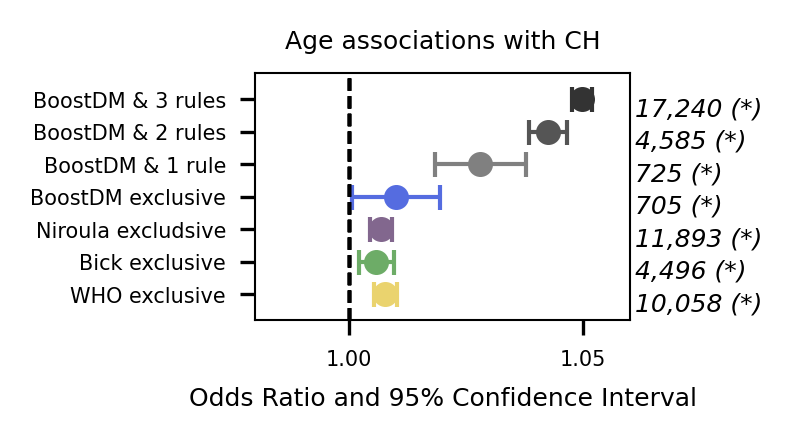

In [26]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.7, 1.5), dpi=300)
xlimit = 1.06
ylimit = len(varlist)-1

dic_axis = {'Overlap_all': 'BoostDM & 3 rules',
            'Overlapping_2': 'BoostDM & 2 rules',
            'Overlapping_1': 'BoostDM & 1 rule',
            'BoostDM_exc': 'BoostDM exclusive',
            'Niroula_exc':'Niroula excludsive',
            'Bick_exc': 'Bick exclusive',
            'WHO_exc':'WHO exclusive'}


for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'Overlap_all' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_1' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_2' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#555555', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#555555", mec="#555555")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'BoostDM_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Niroula_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Bick_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#6DAC67", mec="#6DAC67")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'WHO' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EAD36E", mec="#EAD36E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.001, ylimit-idx-0.5, f"{row['num_muts']:,} (*)", style='italic', size=6)
    else:
        ax.text(xlimit+0.001, ylimit-idx-0.5, str(row['num_muts'])+' (ns)', style='italic', size=6)
        
        
ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.98, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 2.2 Gene specific age associations

In [35]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'CHEK2':
        matrix = mat[(mat['ASXL1_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'MDM4':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    return matrix

### TET2

In [33]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []  

ggg = 'TET2'

for gene in ['Overlap_all', 'BoostDM_exc', 'Niroula_exc', 'Bick_exc', 'WHO_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(np.nan)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts', 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]

    
varlist

Optimization terminated successfully.
         Current function value: 0.081075
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006807
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.058175
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058175
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058175
         Iterations 9


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,Overlap_all,5170,1.037380,1.033604,1.041169,1.265357e-86,0.008836,sig,6.326783e-86
1,BoostDM_exc,271,1.004348,0.989514,1.019405,5.676717e-01,0.006832,ns,8.872412e-01
2,Niroula_exc,3380,1.000306,0.996088,1.004541,8.872412e-01,0.000562,ns,8.872412e-01
3,Bick_exc,3380,1.000306,0.996088,1.004541,8.872412e-01,0.000562,ns,8.872412e-01
4,WHO_exc,3380,1.000306,0.996088,1.004541,8.872412e-01,0.000562,ns,8.872412e-01


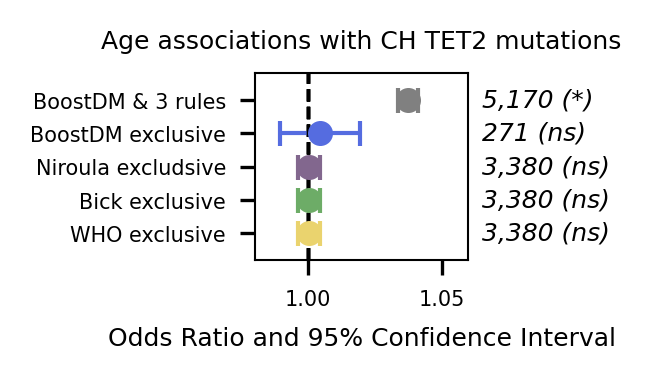

In [36]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(4, 1.3), dpi=300)
xlimit = 1.06
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'Overlap_all' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_1' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_2' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#555555', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#555555", mec="#555555")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'BoostDM_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Niroula_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Bick_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#6DAC67", mec="#6DAC67")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'WHO' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[dic_axis[row.gene]], xerr=ci,
                 ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EAD36E", mec="#EAD36E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.005, ylimit-idx-0.2, f"{int(row['num_muts']):,} (*)", style='italic', size=6)
    elif row['sig'] == 'ns':
        ax.text(xlimit+0.005, ylimit-idx-0.2, f"{int(row['num_muts']):,} (ns)", style='italic', size=6)
        
ax.set_title('Age associations with CH '+ggg+' mutations', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.98, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

## 3. IDH2 Age association

In [59]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

In [38]:
#Select mutations based on driver call

IDH2_140 = boostDM_predictions[(boostDM_predictions['Prot_pos']==140)&\
                         (boostDM_predictions['SYMBOL']=='IDH2')]['patient'].to_list()

IDH2_172 = boostDM_predictions[(boostDM_predictions['Prot_pos']==172)&\
                         (boostDM_predictions['SYMBOL']=='IDH2')]['patient'].to_list()

ukb200K_ch_cancer['IDH2_140'] = np.where(ukb200K_ch_cancer['patient'].isin(IDH2_140), 1, 0)
ukb200K_ch_cancer['IDH2_172'] = np.where(ukb200K_ch_cancer['patient'].isin(IDH2_172), 1, 0)
ukb200K_ch_cancer['IDH2_140'].value_counts()

0    432507
1        49
Name: IDH2_140, dtype: int64

In [39]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['num_CH_potential']<2]
len(ukb200K_ch_cancer_logistic)

432556

In [40]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []

ggg = 'IDH2'

for gene in ['IDH2_140', 'IDH2_172', 'IDH2_passenger', 'IDH2_potential']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['CH_potential']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()

        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts' , 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.001440
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000318
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.072474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.073110
         Iterations 8


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,IDH2_140,49,1.095534,1.048784,1.144367,0.000041,0.041769,sig,0.000165
1,IDH2_172,9,1.017233,0.935428,1.106193,0.689565,0.019626,ns,0.730638
2,IDH2_passenger,4453,1.000649,0.996961,1.004350,0.730638,0.001962,ns,0.730638
3,IDH2_potential,4502,1.001476,0.997802,1.005164,0.431533,0.001967,ns,0.730638


/tmp/jobs/jramis/9759392/ipykernel_30520/758073729.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


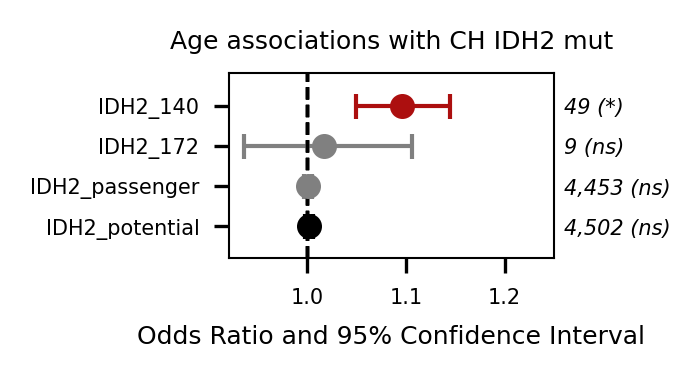

In [41]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.4, 0.8), dpi=300)
xlimit = 1.25
ylimit = len(varlist)-1

color_dic = {
    'IDH2_140':'#ac0f0f',
    'IDH2_172':'grey',
    'IDH2_passenger':'grey',
    'IDH2_potential':'k'}
    
for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
             ecolor=color_dic[row.gene], capsize=3, linestyle='None', linewidth=1, marker="o", 
             markersize=5, mfc=color_dic[row.gene], mec=color_dic[row.gene])
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=5)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=5)
        
        
ax.set_title('Age associations with CH '+ggg+' mut', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.92, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks([1,1.1,1.2], fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

### Analysis to asses how SNV frequency afects most known hotspots

In [39]:
ID_muts = []
for i in range(len(boostDM_predictions)):
    row = boostDM_predictions.iloc[i,:]
    ID_mut = row['SYMBOL']+'_'+row['AA_change'].split('/')[0]+str(row['Prot_pos']).split('.')[0]+row['AA_change'].split('/')[-1]
    ID_muts.append(ID_mut)
boostDM_predictions['ID_mut']= ID_muts

In [40]:
boostDM_predictions[boostDM_predictions['SYMBOL']=='SRSF2']['ID_mut'].value_counts()

SRSF2_R186L    322
SRSF2_P95H     201
SRSF2_R180G    133
SRSF2_R94H      99
SRSF2_P95R      92
              ... 
SRSF2_S179P      1
SRSF2_E215K      1
SRSF2_E53K       1
SRSF2_R203M      1
SRSF2_D19N       1
Name: ID_mut, Length: 597, dtype: int64

In [41]:
# Select a negative control
a = boostDM_predictions[(boostDM_predictions['Drivers_12genes']==0)&\
                          (boostDM_predictions['SYMBOL']=='IDH2')]['ID_mut'].value_counts().reset_index()

a[a['ID_mut']>50]

,index,ID_mut
0,IDH2_D225N,286
1,IDH2_W21S,245
2,IDH2_A22V,168
3,IDH2_V8A,135
4,IDH2_Y238H,106
5,IDH2_V335I,99
6,IDH2_V305M,90
7,IDH2_G16D,87
8,IDH2_R377H,76
9,IDH2_D56E,70


In [50]:
boostDM_predictions[(boostDM_predictions['Prot_pos']==140)&\
                   (boostDM_predictions['SYMBOL']=='IDH2')]

,name_file,#CHROM,POS,ID,REF,ALT,QUAL,AD_alt,DP,VAF_alt,Consequence,IMPACT,SYMBOL,ENST,CDS_pos,Prot_pos,AA_change,rs_ID,ENSP,EUR_AF,gnomAD_AF,gnomAD_AF_NFE,FILTER,patient,rep,rep2,Occur,poN,ID2,Drivers_12genes,age_group,ID_mut,boostDM_score,BoostDM,Niroula,Bick,WHO,BoostDM_exc,Niroula_exc,Bick_exc,WHO_exc,Overlap_all,Overlapping_1,Overlapping_2
3753,/home/dnanexus/src/results/1102470_23143_0_0.filt,15,90088702,.,C,T,.,3,87,0.034483,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,weak_evidence,1102470,"15:90088702,C/T","15:90088702,C/T-1102470",125,"15:90088702,C",15-90088702-T,1,61-65,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
6776,/home/dnanexus/src/results/1190819_23143_0_0.filt,15,90088702,.,C,T,.,18,69,0.260870,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,PASS,1190819,"15:90088702,C/T","15:90088702,C/T-1190819",125,"15:90088702,C",15-90088702-T,1,66-72,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
9507,/home/dnanexus/src/results/1269903_23143_0_0.filt,15,90088702,.,C,T,.,4,34,0.117647,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,PASS,1269903,"15:90088702,C/T","15:90088702,C/T-1269903",125,"15:90088702,C",15-90088702-T,1,61-65,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
10540,/home/dnanexus/src/results/1297667_23143_0_0.filt,15,90088702,.,C,T,.,3,63,0.047619,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,PASS,1297667,"15:90088702,C/T","15:90088702,C/T-1297667",125,"15:90088702,C",15-90088702-T,1,56-60,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
11571,/home/dnanexus/src/results/1327962_23143_0_0.filt,15,90088702,.,C,T,.,3,55,0.054545,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,orientation;weak_evidence,1327962,"15:90088702,C/T","15:90088702,C/T-1327962",125,"15:90088702,C",15-90088702-T,1,66-72,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173028,/home/dnanexus/src/results9/5425220_23143_0_0....,15,90088702,.,C,T,.,9,63,0.142857,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,PASS,5425220,"15:90088702,C/T","15:90088702,C/T-5425220",125,"15:90088702,C",15-90088702-T,1,66-72,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
173080,/home/dnanexus/src/results9/5426870_23143_0_0....,15,90088703,.,G,A,.,3,64,0.046875,missense_variant,MODERATE,IDH2,ENST00000330062,418.0,140.0,R/W,rs267606870&CM106819&COSV57469615&COSV57472768,ENSP00000331897,0.0,0.000000,0.000000,weak_evidence,5426870,"15:90088703,G/A","15:90088703,G/A-5426870",7,"15:90088703,G",15-90088703-A,1,51-55,IDH2_R140W,0.956676,1,1,1,1,0,0,0,0,1,0,0
173561,/home/dnanexus/src/results9/5440528_23143_0_0....,15,90088702,.,C,T,.,17,56,0.303571,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,germline,5440528,"15:90088702,C/T","15:90088702,C/T-5440528",125,"15:90088702,C",15-90088702-T,1,66-72,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0
175631,/home/dnanexus/src/results9/5499112_23143_0_0....,15,90088702,.,C,T,.,5,45,0.111111,missense_variant,MODERATE,IDH2,ENST00000330062,419.0,140.0,R/Q,rs121913502&CM106818&COSV57468751&COSV57469541,ENSP00000331897,0.0,0.000032,0.000053,PASS,5499112,"15:90088702,C/T","15:90088702,C/T-5499112",125,"15:90088702,C",15-90088702-T,1,46-50,IDH2_R140Q,0.986749,1,1,1,1,0,0,0,0,1,0,0


In [51]:
#Select mutations based on driver call

IDH2_R140 = boostDM_predictions[(boostDM_predictions['Prot_pos']==140)&\
                   (boostDM_predictions['SYMBOL']=='IDH2')]['patient'].to_list()
ukb200K_ch_cancer['IDH2_R140'] = np.where(ukb200K_ch_cancer['patient'].isin(IDH2_R140), 1, 0)

SF3B1_K700E = boostDM_predictions[(boostDM_predictions['ID_mut']=='SF3B1_K700E')]['patient'].to_list()
ukb200K_ch_cancer['SF3B1_K700E'] = np.where(ukb200K_ch_cancer['patient'].isin(SF3B1_K700E), 1, 0)

SRSF2_P95H = boostDM_predictions[(boostDM_predictions['ID_mut']=='SRSF2_P95H')]['patient'].to_list()
ukb200K_ch_cancer['SRSF2_P95H'] = np.where(ukb200K_ch_cancer['patient'].isin(SRSF2_P95H), 1, 0)

DNMT3A_R882H = boostDM_predictions[(boostDM_predictions['ID_mut']=='DNMT3A_R882H')]['patient'].to_list()
ukb200K_ch_cancer['DNMT3A_R882H'] = np.where(ukb200K_ch_cancer['patient'].isin(DNMT3A_R882H), 1, 0)

U2AF1_Q157P = boostDM_predictions[(boostDM_predictions['ID_mut']=='U2AF1_Q157P')]['patient'].to_list()
ukb200K_ch_cancer['U2AF1_Q157P'] = np.where(ukb200K_ch_cancer['patient'].isin(U2AF1_Q157P), 1, 0)

DNMT3A_R55H = boostDM_predictions[(boostDM_predictions['ID_mut']=='DNMT3A_R55H')]['patient'].to_list()
ukb200K_ch_cancer['DNMT3A_R55H'] = np.where(ukb200K_ch_cancer['patient'].isin(DNMT3A_R55H), 1, 0)

IDH2_G16D = boostDM_predictions[(boostDM_predictions['ID_mut']=='IDH2_G16D')]['patient'].to_list()
ukb200K_ch_cancer['IDH2_G16D'] = np.where(ukb200K_ch_cancer['patient'].isin(IDH2_G16D), 1, 0)

ukb200K_ch_cancer['IDH2_R140'].value_counts()

0    432507
1        49
Name: IDH2_R140, dtype: int64

In [53]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['num_CH_potential']<2]
len(ukb200K_ch_cancer_logistic)

432556

In [54]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc
import random


name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []


for gene in ['U2AF1_Q157P', 'SRSF2_P95H', 'SF3B1_K700E', 'IDH2_R140', 'DNMT3A_R882H']:   
    CH_driver_matrix = gene_matrix(ukb200K_ch_cancer_logistic, gene.split('_')[0]).reset_index(drop=True)
    
    CH_driver = CH_driver_matrix[(CH_driver_matrix[gene]==1)|(CH_driver_matrix['CH_potential']==0)]
    num_mut = len(CH_driver[(CH_driver[gene] == 1)])
    model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver).fit()

    name.append(gene)
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    
    
    # Set the seed for reproducibility
    seed_value = 42
    random.seed(seed_value)
    # Your list of items
    items_list = CH_driver_matrix.index[CH_driver_matrix[gene] == 1].tolist()
    print(len(items_list))
    nonpotential_index = CH_driver_matrix.index[CH_driver_matrix['CH_potential'] == 0].tolist()
    # Select nine random items
    selected_items = random.sample(items_list, 9)
    # Print the result
    print(selected_items)

    CH_driver_reduce = CH_driver_matrix.iloc[selected_items+nonpotential_index,:]
    num_mut = len(CH_driver_reduce[(CH_driver_reduce[gene] == 1)])
    model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_reduce).fit()

    name.append(gene+'_less')
    num_muts.append(num_mut)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    rsquare.append(model_hematopost.prsquared)
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    
varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts' , 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.001198
         Iterations 17
42
[301329, 81273, 4218, 140555, 124529, 111874, 86225, 79476, 79051]
Optimization terminated successfully.
         Current function value: 0.000281
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.002562
         Iterations 15
97
[275802, 46323, 12566, 306956, 90073, 85928, 79985, 52155, 44954]
Optimization terminated successfully.
         Current function value: 0.000288
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.002791
         Iterations 15
103
[278180, 41670, 20960, 311865, 117118, 112052, 95076, 46909, 40627]
Optimization terminated successfully.
         Current function value: 0.000287
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.001440
         Iterations 16
49
[285139, 52679, 33379, 133993, 132937, 129322, 63534, 50440, 2350

,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,U2AF1_Q157P,42,1.205561,1.128253,1.288166,3.228022e-08,0.084732,sig,8.070054e-08
1,U2AF1_Q157P_less,9,1.363915,1.113299,1.670948,2.735039e-03,0.132097,sig,4.558399e-03
2,SRSF2_P95H,97,1.165270,1.121238,1.211031,7.104925e-15,0.073872,sig,3.552463e-14
3,SRSF2_P95H_less,9,1.202473,1.044796,1.383947,1.014025e-02,0.109968,sig,1.448607e-02
4,SF3B1_K700E,103,1.109489,1.075047,1.145035,1.064892e-10,0.043735,sig,3.549639e-10
5,SF3B1_K700E_less,9,1.077751,0.978045,1.187621,1.305983e-01,0.113536,ns,1.632479e-01
6,IDH2_R140,49,1.095534,1.048784,1.144367,4.119534e-05,0.041769,sig,8.239067e-05
7,IDH2_R140_less,9,1.014760,0.934579,1.101821,7.271697e-01,0.131525,ns,7.271697e-01
8,DNMT3A_R882H,877,1.038416,1.029267,1.047647,6.907319e-17,0.007683,sig,6.907319e-16
9,DNMT3A_R882H_less,9,1.021022,0.937408,1.112095,6.331952e-01,0.039613,ns,7.035502e-01


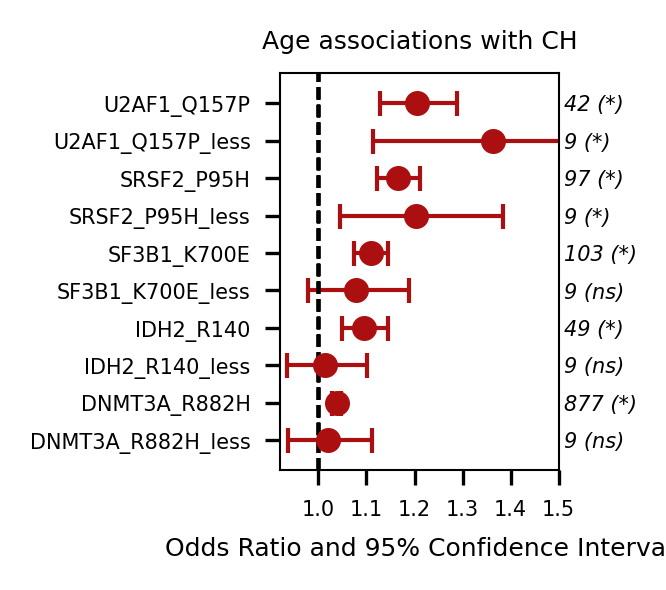

In [55]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(2.8, 2), dpi=300)
xlimit = 1.5
ylimit = len(varlist)-1

    
for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
             ecolor='#ac0f0f', capsize=3, linestyle='None', linewidth=1, marker="o", 
             markersize=5, mfc='#ac0f0f', mec='#ac0f0f')
    plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (*)", style='italic', size=5)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=5)
        
        
ax.set_title('Age associations with CH', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.92, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks([1, 1.1, 1.2, 1.3, 1.4, 1.5], fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=6)


plt.show()

In [56]:
# Set the seed for reproducibility
seed_value = 1234
random.seed(seed_value)

name_mutation = []
OR_list = []
qvalues_list =[]
sig_list=[]

for ggg in ['IDH2_R140', 'DNMT3A_R882H', 'DNMT3A_R55H', 'IDH2_G16D']:
    
    CH_driver_matrix = gene_matrix(ukb200K_ch_cancer_logistic, ggg.split('_')[0]).reset_index(drop=True)
    items_list = CH_driver_matrix.index[CH_driver_matrix[ggg] == 1].tolist()
    print(len(items_list))
    nonpotential_index = CH_driver_matrix.index[CH_driver_matrix['CH_potential'] == 0].tolist()
    exclude_list = []
    sel_it = []

    OR = []
    cilow = []
    ciup = []
    rsquare = []
    pval = []
    sig = []
    num_muts = []

    for _ in range(5):

        # Select nine random items
        selected_items = random.sample(items_list, 9)
        print(selected_items)
        exclude_list = exclude_list+selected_items
        items_list = [x for x in items_list if x not in exclude_list] 
        print(len(items_list))
        sel_it=sel_it+selected_items

        CH_driver_mat = CH_driver_matrix.iloc[selected_items+nonpotential_index,:]
        num_mut = len(CH_driver_mat[(CH_driver_mat[gene] == 1)])
        model_hematopost = smf.logit(formula= ggg+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_mat).fit()
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')

    if len(sel_it) != len(set(sel_it)):
        print("There are repetitions in the list.")
    else:
        print("No repetitions in the list.")

    varlist = pd.DataFrame(list(zip(num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['num_muts' , 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

    import math
    q_value = []
    q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
    num_pval = -1
    for x in varlist.pval:
        if math.isnan(x):
            q_value.append(np.nan)
        else:
            num_pval=num_pval+1
            q_value.append(q_val[num_pval])
    varlist["q_value"] = q_value
    varlist['sig'] = ['sig' if qval <= 0.05 else 'ns' if qval > 0.05 else np.nan for qval in varlist.q_value]

    name_mutation=name_mutation+([ggg] * 5)

    OR_list = OR_list+list(varlist['OR'])
    qvalues_list = qvalues_list+list(varlist['q_value'])
    sig_list= sig_list+list(varlist['sig'])
Final_list = pd.DataFrame(list(zip(name_mutation, OR_list, qvalues_list, sig_list)),\
                                      columns = ['name_mutation' , 'OR_list', 'qvalues_list', 'sig_list'])
Final_list

49
[185748, 52679, 25618, 49945, 267354, 37527, 290900, 303063, 50440]
40
Optimization terminated successfully.
         Current function value: 0.000311
         Iterations 20
[182427, 155979, 43333, 304410, 301689, 321292, 265023, 255224, 129322]
31
Optimization terminated successfully.
         Current function value: 0.000290
         Iterations 19
[63534, 95072, 227280, 65456, 33379, 172164, 168676, 109680, 310642]
22
Optimization terminated successfully.
         Current function value: 0.000286
         Iterations 20
[298652, 268493, 220654, 104634, 274285, 235037, 68716, 133914, 218476]
13
Optimization terminated successfully.
         Current function value: 0.000289
         Iterations 19
[179453, 132937, 227960, 154732, 178874, 156052, 133993, 285139, 289773]
4
Optimization terminated successfully.
         Current function value: 0.000304
         Iterations 20
No repetitions in the list.
877
[182738, 212316, 261326, 7023, 203806, 27317, 2371, 131630, 62814]
868
Optimizatio

,name_mutation,OR_list,qvalues_list,sig_list
0,IDH2_R140,1.049901,0.307009,ns
1,IDH2_R140,1.172229,0.040054,sig
2,IDH2_R140,1.226384,0.040054,sig
3,IDH2_R140,1.084158,0.179638,ns
4,IDH2_R140,1.047795,0.307009,ns
5,DNMT3A_R882H,1.052237,0.441094,ns
6,DNMT3A_R882H,1.062438,0.441094,ns
7,DNMT3A_R882H,1.018882,0.668045,ns
8,DNMT3A_R882H,1.061781,0.441094,ns
9,DNMT3A_R882H,1.021126,0.668045,ns


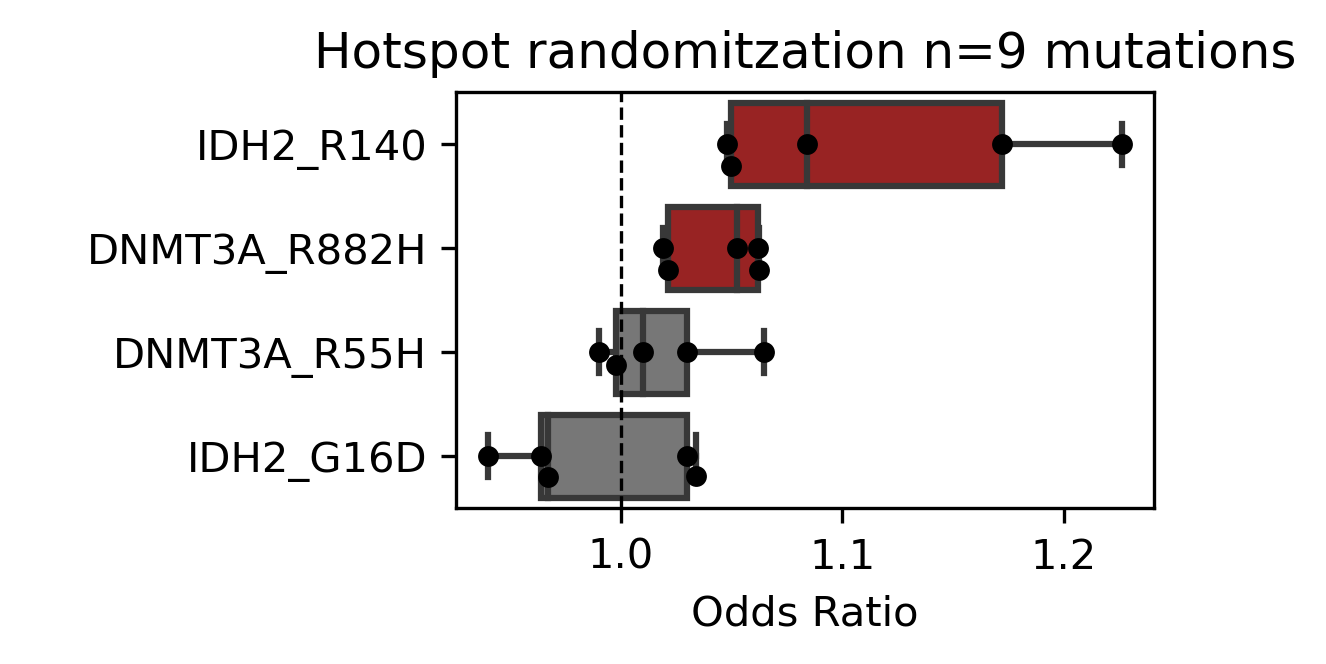

In [57]:
plt.figure(figsize=(3, 1.8))

# Define custom colors for the boxplots
custom_colors = ['#ac0f0f', '#ac0f0f', '#777777', '#777777']

ax = sns.boxplot(y="name_mutation", x="OR_list", data=Final_list, showfliers=False, palette=custom_colors)
ax = sns.swarmplot(y="name_mutation", x="OR_list", data=Final_list, color=".0")

# Add a vertical line at y=1
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')

# Set labels and title
plt.xlabel('Odds Ratio')
plt.ylabel(' ')
plt.title('Hotspot randomitzation n=9 mutations')

# Show the plot
plt.show()